# Assignment 6: Convolutional Networks

Before we start, we should assure that we have activated CUDA -- otherwise training might take very long.
In Google Colaboratory:

1. Check the options Runtime -> Change Runtime Type on top of the page.
2. In the popup window, select hardware accelerator GPU.

Afterward, the following command should run successfully:

In [100]:
import torch
from tqdm import tqdm
if torch.cuda.is_available():
  print("Successfully enabled CUDA processing")
else:
  print("CUDA processing not available. Things will be slow :-(")

Successfully enabled CUDA processing


## Dataset

In PyTorch, a dataset stores a list of input and target tensors $(X^n, T^n)$.
In case of **MNIST** dataset, the inputs are $X^n \in \mathbb R^{28\times28}$ and $T^n \in \{0,\ldots,9\}$.
More precisely, the data in the dataset is provided in form of `PIL.Image.Image`, which represents an image class with some more functionality, and pixel values in range $[0, 255]$.
In order to convert these images into `torch.Tensor`'s in range $[0,1]$, we can use the [ToTensor](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html) transform.
Furthermore, in `PyTorch` batches are created from datasets using the [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) class.


### Task 1: Dataset Loading


Here, we use the [MNIST dataset](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html) of gray images for categorical classification.

Write a function that returns the training and the testing set of MNIST, using the given transform.

In [101]:
import torch
import torchvision

In [102]:


def datasets(transform):
  trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
  testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

  return trainset, testset

### Test 1: Data Types

When we create the dataset with `transform=None`, all inputs shall be of type `PIL.Image.Image`, and all targets are integral.

In [103]:
import PIL
trainset, testset = datasets(transform=None)

for x,t in trainset:
  # check datatype of input x
  assert isinstance(x, PIL.Image.Image)
  # check datatype of target t
  assert isinstance(t, int)

### Task 2: Data Loaders


Create the dataset with transform `ToTensor`. Create two data loaders, one for the training set and one for the testing set. The training batch size should be $B=64$, for the testing set, you can select any batch size of your choice.


In [104]:
transform = torchvision.transforms.ToTensor()
trainset, testset = datasets(transform=transform)

B = 64
trainloader = torch.utils.data.DataLoader(dataset = trainset, batch_size=B)
testloader = torch.utils.data.DataLoader(dataset = testset, batch_size=B)

### Test 2: Batches

Check that all batches generated by the training set data loader have the batch size of $B$ -- except for the last batch, which you need to compute by yourself (you might want to make use of the modulo operator `%`).

Afterward, we check that all inputs and targets are of type `torch.Tensor`, that all input values are in range $[0,1]$ and that all target values are in range $[0,9]$.

In [105]:
len(trainset) % B

32

In [106]:
# compute the size of last batch
last_batch = len(trainset) % B

for x,t in trainloader:
  # check datatype, size and content of x
  assert isinstance(x, torch.Tensor)
  assert(torch.all(x >= 0)) and torch.all(x <= 1)  
  assert len(x)==B or len(x) == last_batch

  # check datatype, size and content of t
  assert isinstance(t, torch.Tensor)
  assert(torch.all(t >= 0)) and torch.all(t <= 9)
  assert len(t)==B or len(t) == last_batch

## Networks
As last week, we will rely on [Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) to create networks with particular lists of consecutive layers.
Particularly, we will investigate two different versions of networks, one fully-connected network and one convolutional network, with the same number of learnable layers.

### Task 3: Fully-Connected Network


Implement a function that returns a three-layer fully-connected network in `pytorch`.
Use $\tanh$ as activation function between the two fully-connected layers, and provide the possibility to change the number of inputs $D$, the number of hidden neurons $K$ and the number of outputs $O$.
Use the following layers:

1. A [Flatten layer](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) to turn the $28\times28$ pixel image (2D) into a $28\cdot28$ pixel vector (1D).
2. A [fully-connected layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) with D input neurons and K outputs.
3. A [$\tanh$ activation function](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html).
4. A fully-connected layer with K input neurons and K outputs.
5. A $\tanh$ activation function.
6. A fully-connected layer with K input neurons and O outputs.

In [107]:
def fully_connected(D, K, O):
  return torch.nn.Sequential(
    # no parameters are required in flatten
    torch.nn.Flatten(),
    torch.nn.Linear(in_features= D, out_features=K),
    torch.nn.Tanh(),
    torch.nn.Linear(in_features= K, out_features=K),
    torch.nn.Tanh(),
    torch.nn.Linear(in_features= K, out_features=O),

  )

In [108]:
from torchsummary import summary

fc = fully_connected(D=28*28, K=100, O=10 )
network = fc
device = torch.device("cuda")
network = network.to(device)
summary(network, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 100]          78,500
              Tanh-3                  [-1, 100]               0
            Linear-4                  [-1, 100]          10,100
              Tanh-5                  [-1, 100]               0
            Linear-6                   [-1, 10]           1,010
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.34
Estimated Total Size (MB): 0.35
----------------------------------------------------------------


### Task 4: Convolutions Output (theoretical question)

Consider the network as defined in Task 5.
Assume that the input is a $28\times28$ grayscale image.
How many hidden neurons do we need in the final fully-connected layer for a given number $Q_2$ of output channels of the second convolution?

![title](appendix/pytorch_dim_output.png)
![title](appendix/dim_output.png)
![title](appendix/maxpooling_dim_output.png)

In [109]:
import math
def output_dim(features_in, kernel_size, padding, stride, dilation = 1):
    """floor just returns rounded down to nearest int

    :param features_in: _description_
    :type features_in: _type_
    :param kernel_size: _description_
    :type kernel_size: _type_
    :param padding: _description_
    :type padding: _type_
    :param stride: _description_
    :type stride: _type_
    """
    return math.floor((features_in + 2 * padding - dilation * (kernel_size - 1) -1) / stride ) +1

In [110]:
print('first layer output dimensions: ', 
      output_dim(features_in = 28 , kernel_size = 5, padding = 2, stride = 1))
print('first maxpooling output dimensions: ', 
      output_dim(features_in = 28 , kernel_size = 2, padding = 0, stride = 2))
print('second layer output dimensions: ', 
      output_dim(features_in = 14 , kernel_size = 5, padding = 2, stride = 1))
print('second maxpooling output dimensions: ', 
      output_dim(features_in = 14 , kernel_size = 2, padding = 0, stride = 2))

first layer output dimensions:  28
first maxpooling output dimensions:  14
second layer output dimensions:  14
second maxpooling output dimensions:  7


How many hidden neurons do we need in the final fully-connected layer for a given number $Q_2$ of output channels of the second convolution?

first layer height <br>
math.floor((features_in + 2 * padding - kernel_size)/ stride ) +1 <br>
(28 + 2 * 2 - 5) / 1 + 1 = 28 <br>
so for height and width 28 x 28 x Q1 <br>
 
max pooling <br>
defaults padding=0, dilation=1, <br>
math.floor((features_in + 2 * padding - dilation  * (kernel_size -1) - 1)/ stride ) +1 <br>
((28 + 2 * 0 -1 * (2 - 1) - 1) / 2) + 1 = 14 x 14 x Q1 <br>

second layer height <br>
so for height and width 14 x 14 x Q2 <br>

max pooling <br>
defaults padding=0, dilation=1, <br>
7 x 7 x Q2 <br>

### Task 5: Convolutional Network

Implement a function that generates a convolutional network with the following layers:

1. A [2D convolutional layer](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) with $Q_1$ channels, kernel size $5\times5$, stride 1 and padding 2.
2. A [2D maximum pooling](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) with pooling size $2\times2$ and stride 2.
3. A $\tanh$ activation function.
4. A 2D convolutional layer with $Q_2$ channels, kernel size $5\times5$, stride 1 and padding 2.
5. A 2D maximum pooling with pooling size $2\times2$ and stride 2.
6. A $\tanh$ activation function.
7. A flattening layer to turn the 3D feature map into a 1D vector.
8. A fully-connected layer with the appropriate number of inputs and $O$ outputs.

In [111]:
def convolutional(Q1, Q2, O):
  return torch.nn.Sequential(
      # careful in_channels = 1 not Q1
      torch.nn.Conv2d(in_channels=1, out_channels=Q1, kernel_size= (5,5), stride=1, padding=2),
      torch.nn.MaxPool2d(kernel_size=(2,2), stride=2),
      torch.nn.Tanh(),
      torch.nn.Conv2d(in_channels=Q1, out_channels=Q2, kernel_size= (5,5), stride=1, padding=2),
      torch.nn.MaxPool2d(kernel_size=(2,2), stride=2),
      torch.nn.Tanh(),
      # flatten without parameters
      torch.nn.Flatten(),
      # ?? why 7 * 7
      torch.nn.Linear(in_features=Q2 * 7 * 7, out_features=O)
  )

In [112]:
from torchsummary import summary

cv = convolutional(Q1 = 16, Q2 =32, O=10 )
network = cv 
device = torch.device("cuda")
network = network.to(device)
summary(network, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             416
         MaxPool2d-2           [-1, 16, 14, 14]               0
              Tanh-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]          12,832
         MaxPool2d-5             [-1, 32, 7, 7]               0
              Tanh-6             [-1, 32, 7, 7]               0
           Flatten-7                 [-1, 1568]               0
            Linear-8                   [-1, 10]          15,690
Total params: 28,938
Trainable params: 28,938
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.23
Params size (MB): 0.11
Estimated Total Size (MB): 0.34
----------------------------------------------------------------


## Network Training
For training and evaluating the network, we rely on standard functionality in PyTorch.
We use the standard [categorical cross-entropy loss](https://pytorch.org/docs/stable/nn.html#loss-functions) together with a [stochastic gradient descent](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) optimizer.
For training, we use the batched implementation of the dataset, for which we perform one update step for each training batch.
After having gone through the full training dataset, we compute accuracy and loss values for the testing set (we simply make use of the testing set for validation).


### Task 6: Training and Validation Loop

Implement a function that takes the network, the number of epochs, and the learning rate.
Select the correct loss function for categorical classification and SGD optimizer.
Iterate the following steps for the given number of epochs:

1. Train the network with all batches of the training data.
2. Compute the testing set loss and testing set accuracy.
3. Store both in a vector.

What do we need to take care of?

Finally, return the lists of validation losses and accuracies.

In [113]:
def accuracy(Z, T):
  # check if we have binary or categorical classification
  # for binary classification, we will have a two-dimensional target tensor
  if len(T.shape) == 2:
    # binary classification
    # If z is equal or larger than the threshold 0.5, then we predict 1, otherwise 0 
    # we use the .float() function to convert the boolean to a float
    # then we compare the prediction with the target and compute the mean
    
    # ??? our data is binary between 0 and 1, so why do you use 0 as threshold ???
    # So only if we use sigmoid activation function for binary or softmax for multi-class
    # after the last layer, we need to use 0.5 as threshold
    return torch.mean(((Z>=0).float() == T).float())

  else:
    # categorical classification
    # the argmax function returns the index of the maximum value
    # we use the .float() function to convert the boolean to a float
    # then we compare the prediction with the target and compute the mean
    # return torch.mean((torch.argmax(Z, dim=1).float() == T).float())
    
    # Y is the index of the maximum value in Z
    Y = torch.argmax(Z, dim=1)
    return torch.mean((Y == T).float())

In [114]:
def train(network, epochs, eta, momentum):
  # select loss function and optimizer
  loss = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(
    network.parameters(), 
    lr=eta,
    momentum= momentum,
  )

  # instantiate the correct device
  device = torch.device("cuda")
  network = network.to(device)

  # collect loss values and accuracies over the training epochs
  val_loss, val_acc = [], []

  for epoch in tqdm(range(epochs)):
    # train network on training data
    for x,t in trainloader:
      # put data to device
      x, t = x.to(device), t.to(device)
      # train
      optimizer.zero_grad()
      # train on training set
      # ... compute network output on training data
      Z = network(x)
      # ... compute loss from network output and target data
      loss_ = loss(Z, t)
      loss_.backward()
      # ... perform parameter update
      optimizer.step()


    # test network on test data
    
    with torch.no_grad():
      batch_val_loss, batch_val_acc = [], []
      for x,t in testloader:
        # put data to device
        x, t = x.to(device), t.to(device)
        # compute validation loss
        Z = network(x)
        # ... compute loss from network output and target data
        loss_ = loss(Z, t)
        # ... remember loss
        batch_val_loss.append(loss_.item())
        # ... compute validation set accuracy
        batch_val_acc.append(accuracy(Z, t).item())
        
      # careful calculate loss and accuracy averaged over batches
      val_loss.append(sum(batch_val_loss) / len(batch_val_loss))
      # ... compute validation set accuracy
      val_acc.append(sum(batch_val_acc) / len(batch_val_acc))


  # return loss and accuracy values
  return val_loss, val_acc

### Task 7: Fully-Connected Training

Create a fully-connected network with $K=100$ hidden and $O=10$ output neurons.
Train the network for 10 epochs with $\eta=0.01$, $momentum=0.9$ and store the obtained test losses and accuracies.
Brave people can also train for 100 epochs (which will take up to 30 minutes).

In [115]:
# why 28*28?
# for the fully connected network we flatten the image pixels to 1 dimension
fc = fully_connected(D=28*28, K=100, O=10 )
fc_loss, fc_acc = train(network = fc, epochs = 10, eta = 0.01, momentum = 0.9)

 10%|█         | 1/10 [00:17<02:34, 17.18s/it]

### Task 8: Convolutional Training


Create a convolutional network with $Q_1=16$ and $Q_2=32$ convolutional channels and $O=10$ output neurons.
Train the network for 10 epochs with $\eta=0.01$, momentum $=0.9$ and store the obtained test losses and accuracies.
Again, 100 epochs will take up to 30 minutes.

In [ ]:
cv = convolutional(Q1 = 16, Q2 =32, O=10 )
cv_loss, cv_acc = train(network= cv, epochs = 10, eta = 0.01, momentum = 0.9)

 20%|██        | 2/10 [02:14<08:56, 67.05s/it]


KeyboardInterrupt: 

### Task 9: Plotting

Plot the two lists of loss values in one plot. Plot the two lists of accuracy values into another plot.

Text(0.5, 1.0, 'Validation Accuracy')

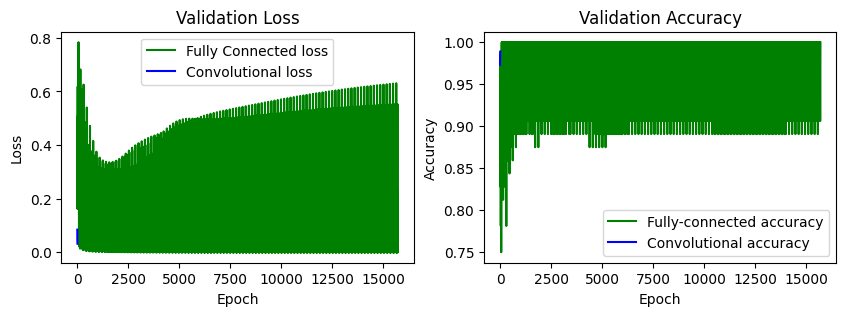

In [ ]:
from matplotlib import pyplot
pyplot.figure(figsize=(10,3))
ax = pyplot.subplot(121)
# plot loss values of FC and CV network over epochs
ax.plot(fc_loss, "g-", label="Fully Connected loss")
ax.plot(cv_loss, "b-", label="Convolutional loss")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
ax.set_title('Validation Loss')

ax = pyplot.subplot(122)
# plot accuracy values of FC and CV network over epochs
ax.plot(fc_acc, "g-", label="Fully-connected accuracy")
ax.plot(cv_acc, "b-", label="Convolutional accuracy")
ax.set_xlabel("Epoch")
ax.set_ylabel('Accuracy')
ax.legend()
ax.set_title('Validation Accuracy')

### Task 10: Learnable Parameters 

Estimate roughly how many learnable parameters the two networks have by analytically computing and adding the number of parameters in each layer.

In [ ]:
fc

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=100, bias=True)
  (2): Tanh()
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): Tanh()
  (5): Linear(in_features=100, out_features=10, bias=True)
)

imagine the edges (weights) of the network

Fully-connected Network:
- first fully-connected layer: 28 * 28 * 100 + bias 100 = 78500
- second fully-connected layer: 100 * 100 + bias 100 = 10100
- third fully-connected layer: 100 * 10 + bias 10 = 1010
- total: 78500 + 10100 + 1010 = 89610

In [ ]:
fc = fully_connected(D=28*28, K=100, O=10 )
network = fc
device = torch.device("cuda")
network = network.to(device)
summary(network, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 100]          78,500
              Tanh-3                  [-1, 100]               0
            Linear-4                  [-1, 100]          10,100
              Tanh-5                  [-1, 100]               0
            Linear-6                   [-1, 10]           1,010
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.34
Estimated Total Size (MB): 0.35
----------------------------------------------------------------


In [ ]:
cv

Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Tanh()
  (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Tanh()
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1568, out_features=10, bias=True)
)

1st layer = 3 * 3 * 3 (kernel) * filter size Q1 32 + bias Q1 32
following layers = kernel * filter Q1 * filter Q2 + bias Q2

Convolutional Network:
- first convolutional layer: kernel 5 * 5  * filter size Q1 16 + bias 16 = 416
- second convolutional layer: kernel 5 * 5 * Q1 16 * Q2 32 + bias 32 = 12832
- fully-connected layer: in_features 1568 * O 10 + bias 10 = 15690
- total: 28,938



Now, compute the number of parameters in the networks by summing the number of parameters in each layer using `pytorch` functionality.
You can use the `numel()` function from a `torch.Tensor` to provide the number of (learnable) parameters stored in a tensor.
How do you obtain this list of all learnable parameters from a `pytorch` [Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)?

In [ ]:
cv = convolutional(Q1 = 16, Q2 =32, O=10 )
network = cv 
device = torch.device("cuda")
network = network.to(device)
summary(network, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             416
         MaxPool2d-2           [-1, 16, 14, 14]               0
              Tanh-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]          12,832
         MaxPool2d-5             [-1, 32, 7, 7]               0
              Tanh-6             [-1, 32, 7, 7]               0
           Flatten-7                 [-1, 1568]               0
            Linear-8                   [-1, 10]          15,690
Total params: 28,938
Trainable params: 28,938
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.23
Params size (MB): 0.11
Estimated Total Size (MB): 0.34
----------------------------------------------------------------


In [ ]:
def parameter_count(network):
  return sum(p.numel() for p in network.parameters() if p.requires_grad)

print("Fully-connected Network:", parameter_count(fc))
print("Convolutional Network:", parameter_count(cv))

Fully-connected Network: 89610
Convolutional Network: 28938
